In [1]:
#Importing the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import absolute, mean, std
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the cleaned data that was exported from Part 1
movies = pd.read_csv('Cleaned_Movies.csv')

#Cleaning nas.
movies = movies.dropna()

#Deleting the first column as it is just a number column
del movies['Unnamed: 0']

#Viewing the data frame head
movies.head()

,genres,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Action,Color,Tim Burton,153,126,13000,390,Vincent Schiavelli,920,162831698,...,0,0,0,0,0,0,0,0,0,0
1,Action,Color,Jon Hess,19,87,29,147,Ian Gomez,683,1200000,...,0,0,0,0,0,0,0,0,0,0
2,Action,Color,Tony Jaa,110,110,0,7,Petchtai Wongkamlao,64,102055,...,0,0,0,0,0,0,0,0,0,0
3,Action,Color,RZA,208,107,561,353,RZA,746,15608545,...,0,0,0,0,0,0,0,0,0,0
4,Action,Color,Joel Schumacher,183,125,541,409,Vivica A. Fox,920,107285004,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Viewing the sums of all the numerical columns
numbers = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = movies.select_dtypes(include = numbers)
num_df.sum()

num_critic_for_reviews       6.024170e+05
duration                     4.026650e+05
director_facebook_likes      2.972990e+06
actor_3_facebook_likes       2.757764e+06
actor_1_facebook_likes       2.804675e+07
gross                        1.892406e+11
num_voted_users              3.826189e+08
cast_total_facebook_likes    4.160418e+07
facenumber_in_poster         5.064000e+03
num_user_for_reviews         1.209215e+06
budget                       1.550602e+11
title_year                   7.320615e+06
actor_2_facebook_likes       7.251143e+06
imdb_score.x                 2.362360e+04
aspect_ratio                 7.707770e+03
movie_facebook_likes         3.333503e+07
imdb_score.y                 2.347000e+04
Action                       9.240000e+02
Adventure                    7.520000e+02
Animation                    1.940000e+02
Biography                    2.370000e+02
Comedy                       1.442000e+03
Crime                        6.920000e+02
Documentary                  4.500

In [4]:
#It looks like there are no values under News and Short movies, so these columns will be removed.
del movies['News']
del movies['Short']

In [5]:
del movies['imdb_score.y']
movies['imdb_score'] = movies['imdb_score.x']
del movies['imdb_score.x']

In [6]:
movies = pd.get_dummies(movies, columns = ['content_rating'], drop_first=True)

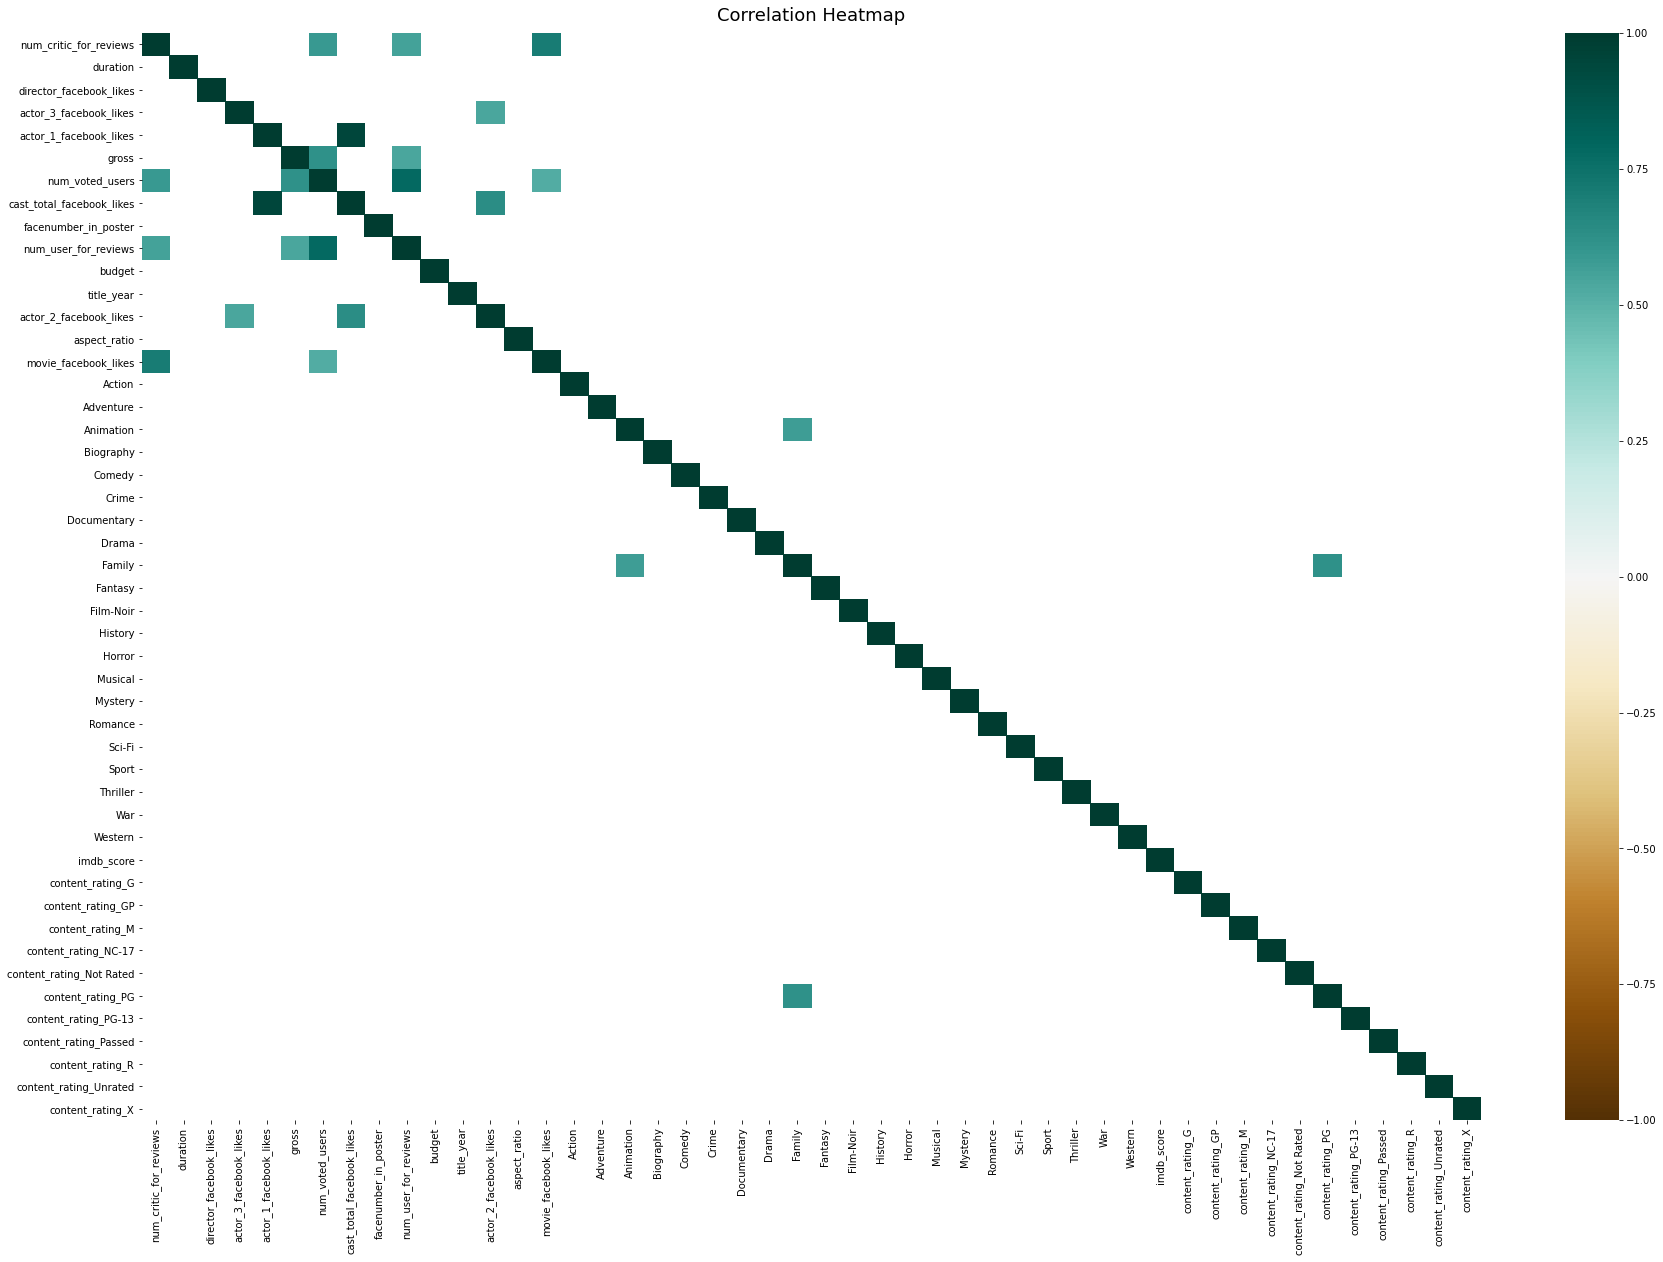

In [7]:
#Viewing the correlated variables once more to determine which variables are correlated
#Only correlations above 0.5 will be displayed to indicate what variables are causing multicollinearity.
#These variables will be removed before the EDA, feature selection, and model building steps.

plt.figure(figsize = (30, 20))
heatmap = sns.heatmap(movies.corr()[movies.corr() >= 0.5], vmin = -1, vmax = 1, cmap = 'BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad = 12);

In [8]:
#Color, languages, and plot keywords will be removed as these features will be of no use to our analysis.
#Color and language are overwhelmingly of one element, and keywords are much too different to be useful
#for building a predictive analytic model.

del movies['color']
del movies['language']
del movies['plot_keywords']

In [9]:
#In addition, variables that were shown to have high correlations with other variables will be deleted, such as number 
#of users who voted on the movie in IMDb, number of user reviews, and number of critic reviews

del movies['num_voted_users']
del movies['num_user_for_reviews']
del movies['num_critic_for_reviews']

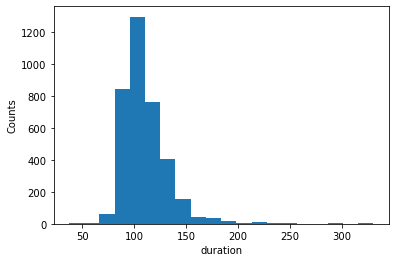

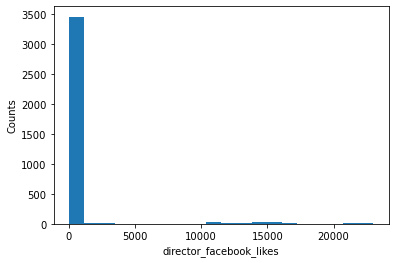

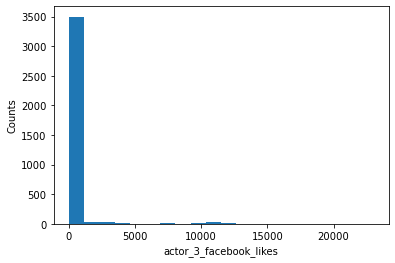

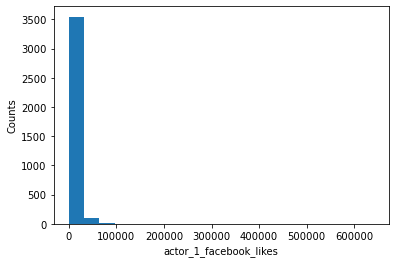

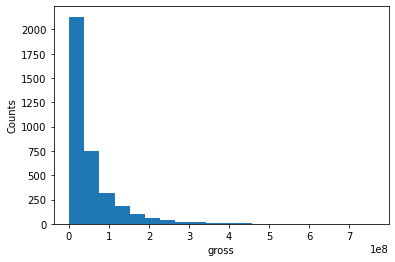

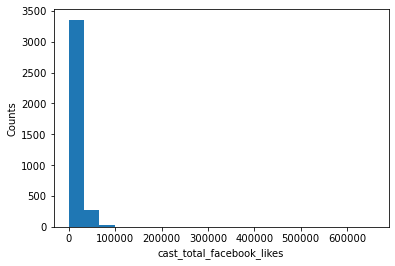

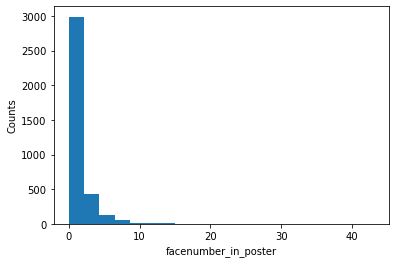

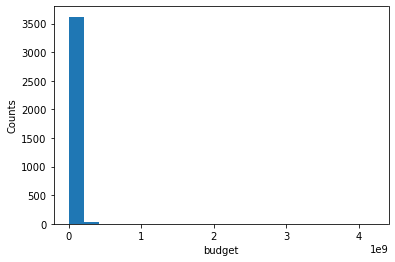

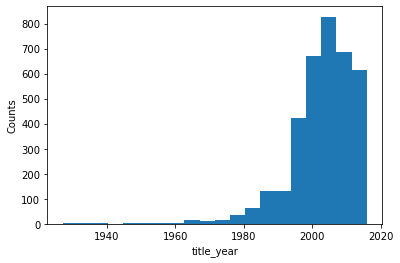

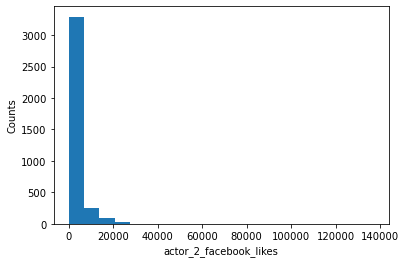

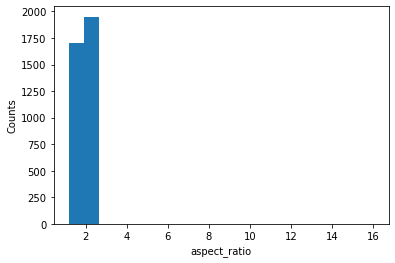

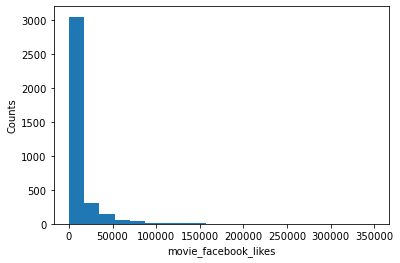

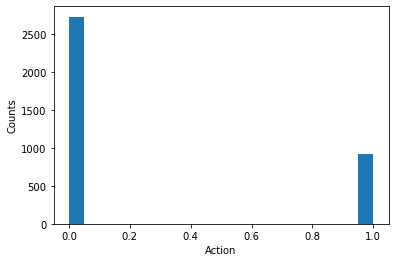

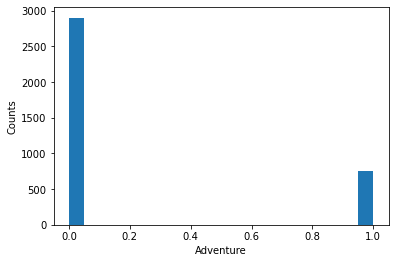

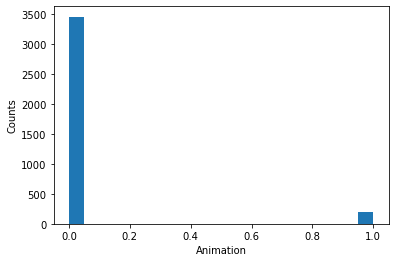

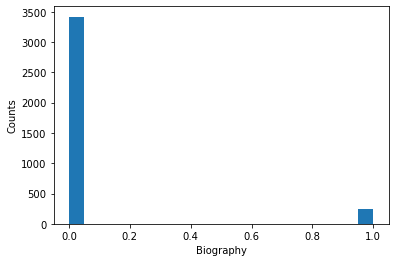

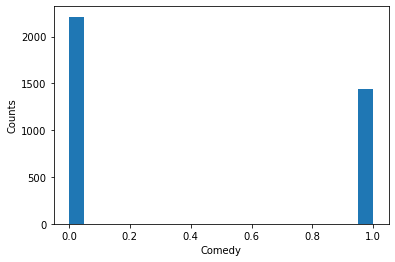

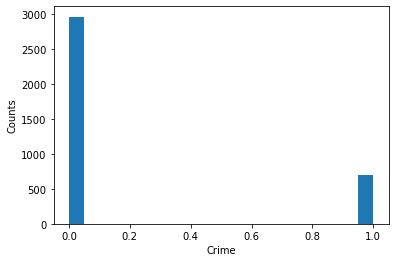

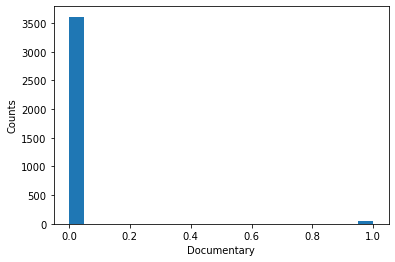

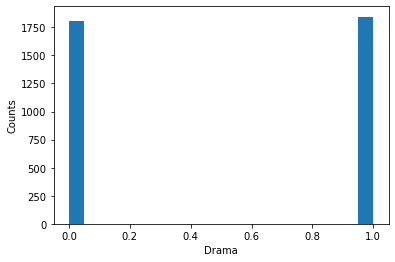

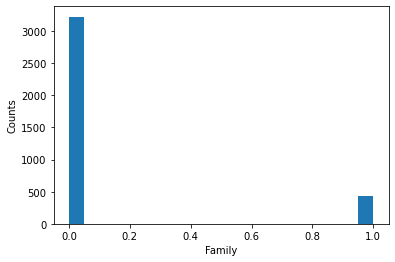

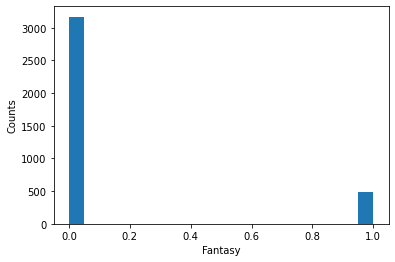

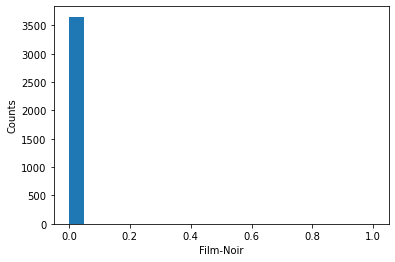

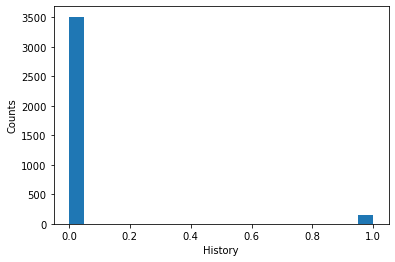

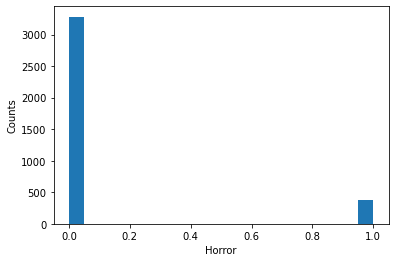

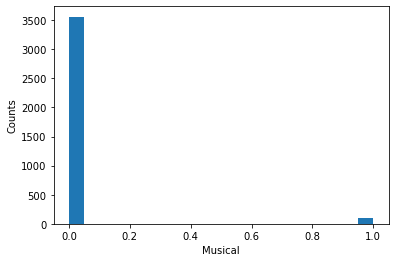

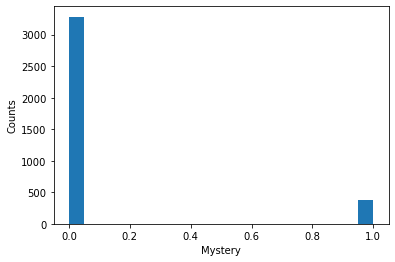

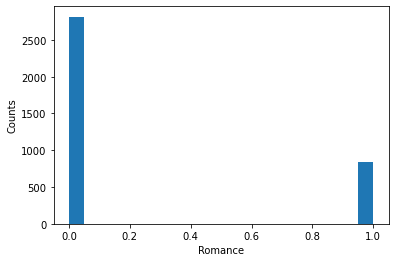

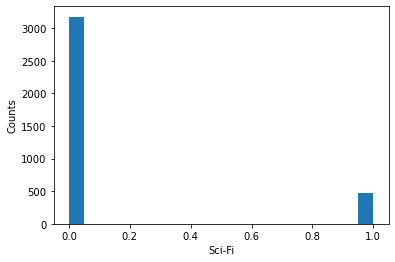

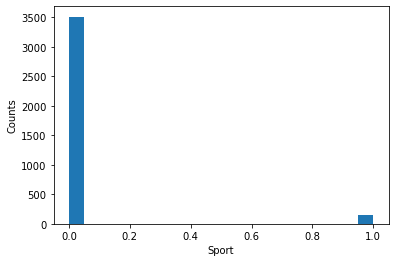

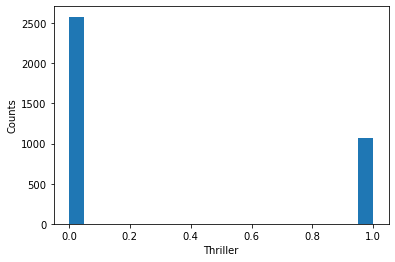

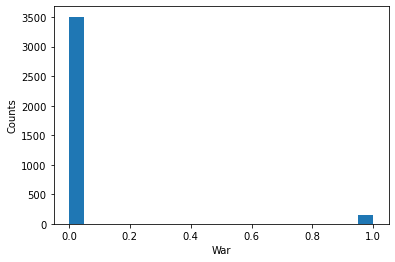

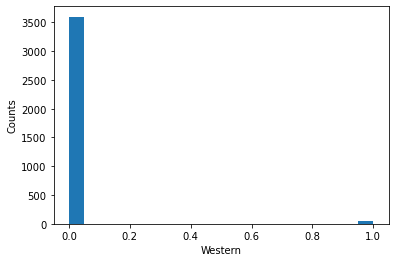

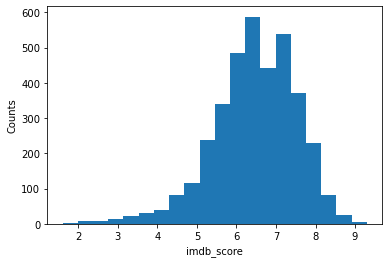

In [10]:
#Generating histograms of the numerical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = movies.select_dtypes(include = numerics)

for i in range(newdf.shape[1]):
    plt.hist(newdf[newdf.columns[i]], bins = 20)
    plt.xlabel(newdf.columns[i])
    plt.ylabel('Counts')
    plt.show()

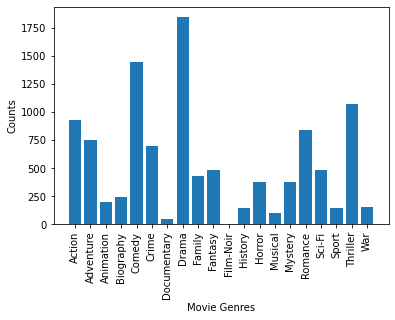

In [11]:
#Generating a bar chart of the movie genres

genre_names = movies.columns[20:40]
sums = [movies[genre].sum() for genre in genre_names]

plt.bar(genre_names, sums)
plt.xlabel('Movie Genres')
plt.ylabel('Counts')
plt.xticks(rotation = 90)
plt.show()

#It appears that Drama, Comedy, Thriller, Action, and Romance are the top 5 movie genres of all time

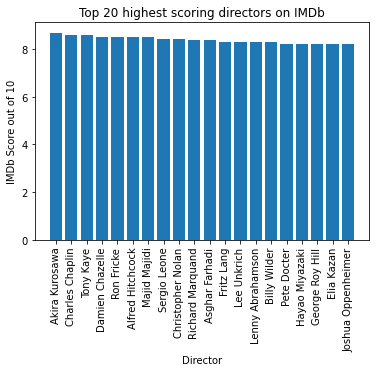

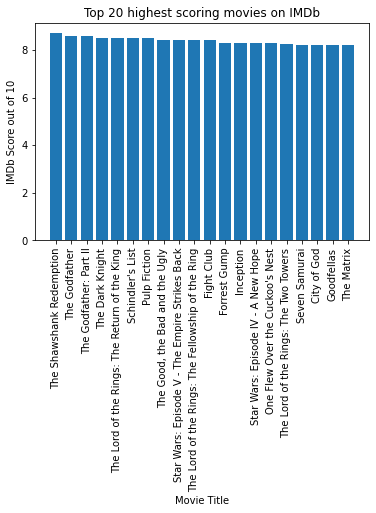

In [12]:
#Constructing a bar chart of the top 20 highest scoring film directors on IMDb and top 20 highest scoring movies on IMDb

IMDB_Score = movies.groupby('director_name').mean().sort_values(by = 'imdb_score', ascending = False)['imdb_score']

plt.bar(IMDB_Score.index[0:20], IMDB_Score[0:20])
plt.xlabel('Director')
plt.ylabel('IMDb Score out of 10')
plt.xticks(rotation = 90)
plt.title('Top 20 highest scoring directors on IMDb')
plt.show()

top20_movies = movies.sort_values(by = 'imdb_score', ascending = False)['movie_title'][0:20]

plt.bar(top20_movies, IMDB_Score[0:20])
plt.xlabel('Movie Title')
plt.ylabel('IMDb Score out of 10')
plt.xticks(rotation = 90)
plt.title('Top 20 highest scoring movies on IMDb')
plt.show()

#All 20 directors and films had scores between 8-8.5

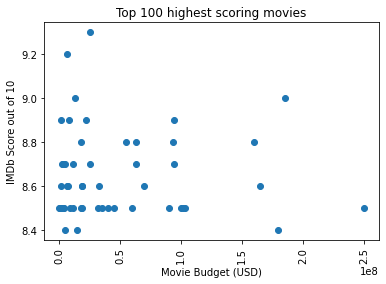

In [13]:
#Plotting IMDb score vs movie budget for the top 50 movies to see if there is a trend 
#between how much is spent on a movie and how well it does among viewers.

#Budgets for the top 50 scoring movies
top50_budgets = movies.sort_values(by = 'imdb_score', ascending = False)['budget'][0:50]

#Scores for the top 50 scoring movies
top50_scores = movies.sort_values(by = 'imdb_score', ascending = False)['imdb_score'][0:50]

plt.scatter(top50_budgets, top50_scores)
plt.xlabel('Movie Budget (USD)')
plt.ylabel('IMDb Score out of 10')
plt.title('Top 100 highest scoring movies')
plt.xticks(rotation = 90)
plt.show()

#It doesn't look like there is a trend between budget and how well a movie performs

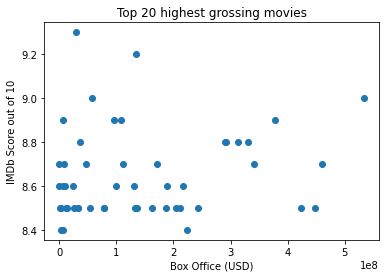

In [14]:
#What about IMDb score vs how much a movie grosses for the top 20 movies?

#Box office for the top 50 movies
top50_gross = movies.sort_values(by = 'imdb_score', ascending = False)['gross'][0:50]

#Scores for the top 50 movies
top50_scores = movies.sort_values(by = 'imdb_score', ascending = False)['imdb_score'][0:50]

plt.scatter(top50_gross, top50_scores)
plt.xlabel('Box Office (USD)')
plt.ylabel('IMDb Score out of 10')
plt.title('Top 20 highest grossing movies')
plt.show()

#Again, there appears to be no trend between how much a film grossed and its IMDb score for the top 50 films

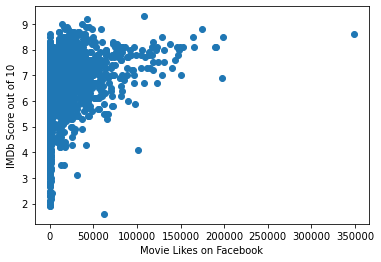

Correlation: 0.2870455013295861


In [15]:
#Plotting IMDb score vs how many likes a movie's Facebook page received.

likes = movies['movie_facebook_likes']
scores = movies['imdb_score']

plt.scatter(likes, scores)
plt.xlabel('Movie Likes on Facebook')
plt.ylabel('IMDb Score out of 10')
plt.show()
print('Correlation: {}'.format(np.corrcoef(likes, scores)[0, 1]))
      
#There appears to be a weak positive correlation between IMDb score and number of Facebook likes

In [16]:
#Deleting movie titles as it is too diverse to be useful in the machine learning models
del movies['movie_title']

In [17]:
#Generating a list of the key predictors to use for the model.

predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 
              'cast_total_facebook_likes', 'facenumber_in_poster', 'budget', 'title_year', 'actor_2_facebook_likes',
              'aspect_ratio', 'movie_facebook_likes', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
              'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 
              'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'content_rating_G', 'content_rating_GP', 'content_rating_M',
              'content_rating_NC-17', 'content_rating_Not Rated', 'content_rating_PG', 'content_rating_PG-13', 
              'content_rating_Passed', 'content_rating_R', 'content_rating_Unrated', 'content_rating_X']




In [18]:
#Four types of ridge regression models will be built: 

#One using KFCV 
#One using a 80-20 train-test split of the data
#One using KFCV with our dataset one-hot encoded to turn the categorical features into binary features for each element
#One using a 80-20 train-test split of the data using the same one-hot encoded features from Model 3. 
#For all models, root mean squared error (RMSE) will be used as the scoring metric.


#Method 1: Ridge regression with KFCV

#Implementing ridge regression
ridge = Ridge(alpha = .001, normalize = True)

#Defining the X (predictors) and y (target) 
X = movies[predictors]
y = movies['imdb_score']

#Scoring the model using a 10-fold cross-validation.
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(ridge, X , y, scoring = 'neg_mean_squared_error', cv=cv, n_jobs=-1)

#Finding absolute values.
scores = absolute(scores)

In [19]:
#Evaluating the RMSE of the model.
print('RMSE: {} ({})'.format(mean(scores), std(scores)))

RMSE: 0.6965167724434038 (0.07868203232391925)


In [20]:
#Method 2: Ridge regression with an 80-20 train-test splitX

#Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 45)

In [21]:
#Fitting the model with the training data.
ridge.fit(X_train, y_train)

Ridge(alpha=0.001, normalize=True)

In [22]:
#Generating numerical predictions.
y_pred = ridge.predict(X_test)

In [23]:
#Evaluating the RMSE of the model.
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 0.8291239254188921


In [24]:
#Method 3: Ridge regression with one-hot encoded variables using KFCV

#One-hot encoding the dataframe to turn the categorical columns into binary columns for each element
moviesdf = pd.get_dummies(data = movies, columns = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'country'], drop_first = True)
moviesdf.head()

,genres,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,cast_total_facebook_likes,facenumber_in_poster,movie_imdb_link,budget,...,country_Romania,country_Russia,country_South Africa,country_South Korea,country_Spain,country_Taiwan,country_Thailand,country_UK,country_USA,country_West Germany
0,Action,126,13000,390,920,162831698,2899,0,http://www.imdb.com/title/tt0103776/?ref_=fn_t...,80000000.0,...,0,0,0,0,0,0,0,0,1,0
1,Action,87,29,147,683,1200000,1139,1,http://www.imdb.com/title/tt0104215/?ref_=fn_t...,3000000.0,...,0,0,0,0,0,0,0,0,1,0
2,Action,110,0,7,64,102055,134,0,http://www.imdb.com/title/tt0785035/?ref_=fn_t...,300000000.0,...,0,0,0,0,0,0,1,0,0,0
3,Action,107,561,353,746,15608545,2377,3,http://www.imdb.com/title/tt1258972/?ref_=fn_t...,15000000.0,...,0,0,0,0,0,0,0,0,1,0
4,Action,125,541,409,920,107285004,2699,3,http://www.imdb.com/title/tt0118688/?ref_=fn_t...,125000000.0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
#Cleaning up the data frame with categories we can't use. 
#The link isn't helpful and the genre is too diverse without helpfulness.
del moviesdf['genres']
del moviesdf['movie_imdb_link']
moviesdf.head()

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,cast_total_facebook_likes,facenumber_in_poster,budget,title_year,actor_2_facebook_likes,...,country_Romania,country_Russia,country_South Africa,country_South Korea,country_Spain,country_Taiwan,country_Thailand,country_UK,country_USA,country_West Germany
0,126,13000,390,920,162831698,2899,0,80000000.0,1992,811,...,0,0,0,0,0,0,0,0,1,0
1,87,29,147,683,1200000,1139,1,3000000.0,1993,155,...,0,0,0,0,0,0,0,0,1,0
2,110,0,7,64,102055,134,0,300000000.0,2008,45,...,0,0,0,0,0,0,1,0,0,0
3,107,561,353,746,15608545,2377,3,15000000.0,2012,561,...,0,0,0,0,0,0,0,0,1,0
4,125,541,409,920,107285004,2699,3,125000000.0,1997,890,...,0,0,0,0,0,0,0,0,1,0


In [26]:
#Defining a new X and y.
X = moviesdf[moviesdf.columns]
y = moviesdf['imdb_score']

In [27]:
#Using another 10-fold cross validation.
ridge = Ridge()
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(ridge, moviesdf[moviesdf.columns] , movies['imdb_score'], scoring = 'neg_mean_squared_error', cv = cv, n_jobs = -1)
scores = absolute(scores)

In [28]:
#Evaluating the RMSE of the model.
print('RMSE: {} ({})'.format(mean(scores), std(scores)))

RMSE: 0.870428947530296 (0.09502606731002068)


In [29]:
#Method 4: Ridge regression with the one-hot encoded features using an 80-20 train-test split.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 45)

In [30]:
#Fitting the model.
ridge.fit(X_train,y_train)

Ridge()

In [31]:
#Predicting the model.
y_pred = ridge.predict(X_test)

In [32]:
#UEvaluating the RMSE of the model.
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 0.9287713414525731


In [33]:
#There were much too many features in the one-hot encoded dataset (moviesdf), so feature selection will be 
#applied to it to see if RMSE can be lowered at all for the models using the one-hot encoded dataset.

#Viewing the head of the one-hot encoded data frame
moviesdf.head()

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,cast_total_facebook_likes,facenumber_in_poster,budget,title_year,actor_2_facebook_likes,...,country_Romania,country_Russia,country_South Africa,country_South Korea,country_Spain,country_Taiwan,country_Thailand,country_UK,country_USA,country_West Germany
0,126,13000,390,920,162831698,2899,0,80000000.0,1992,811,...,0,0,0,0,0,0,0,0,1,0
1,87,29,147,683,1200000,1139,1,3000000.0,1993,155,...,0,0,0,0,0,0,0,0,1,0
2,110,0,7,64,102055,134,0,300000000.0,2008,45,...,0,0,0,0,0,0,1,0,0,0
3,107,561,353,746,15608545,2377,3,15000000.0,2012,561,...,0,0,0,0,0,0,0,0,1,0
4,125,541,409,920,107285004,2699,3,125000000.0,1997,890,...,0,0,0,0,0,0,0,0,1,0


In [34]:
movies.columns

Index(['genres', 'director_name', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'actor_1_name', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'movie_imdb_link', 'country', 'budget',
       'title_year', 'actor_2_facebook_likes', 'aspect_ratio',
       'movie_facebook_likes', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'imdb_score',
       'content_rating_G', 'content_rating_GP', 'content_rating_M',
       'content_rating_NC-17', 'content_rating_Not Rated', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_Passed', 'content_rating_R',
       'content_rating_Unrated', 'content_rating_X'],
      dtype='object')

In [35]:
#Normalizing the IMDb scores to be between 0-1
moviesdf['imdb_score'] = moviesdf['imdb_score']/moviesdf['imdb_score'].max()
moviesdf['imdb_score'].head()

0    0.752688
1    0.548387
2    0.666667
3    0.580645
4    0.397849
Name: imdb_score, dtype: float64

In [36]:
#Creating a list and looping through to format.
moviesdf_list = list(moviesdf.columns)

for x in moviesdf_list:
    x = 'moviesdf["'+x+'"]'

In [37]:
#Getting the ridge regression coefficients then converting the coefficients to a list.
ridge.fit(moviesdf[moviesdf_list], moviesdf["imdb_score"])
coef = ridge.coef_.tolist()

In [38]:
#Displaying the results and formatting it to display next to the name of each categorical value.
for x, z in zip(moviesdf_list,coef):
    z = str(z)
    print(x + ": " + z)

duration: 0.0013489196153999578
director_facebook_likes: 3.116499867789578e-06
actor_3_facebook_likes: 1.2835639564110434e-05
actor_1_facebook_likes: 1.0911418346534231e-05
gross: 1.0523848459342844e-10
cast_total_facebook_likes: -1.0567454041437649e-05
facenumber_in_poster: -0.0037764184903890667
budget: -1.255422432677733e-10
title_year: -0.0016639838492179982
actor_2_facebook_likes: 1.1127554283666156e-05
aspect_ratio: -9.94250748201564e-06
movie_facebook_likes: 1.247202472729348e-06
Action: -2.633848443181595e-05
Adventure: 1.5394977138759587e-05
Animation: 2.176121365082284e-05
Biography: 2.782118852433267e-05
Comedy: -0.00019224484381797898
Crime: -5.487721394400009e-08
Documentary: 7.55620549474662e-06
Drama: 7.008107049044997e-05
Family: 3.785904474389762e-06
Fantasy: 1.5982532492640182e-05
Film-Noir: 1.3366373254374664e-07
History: 1.7271020695840455e-05
Horror: 8.39718469694056e-05
Musical: -2.073540650438778e-06
Mystery: 4.4620091964509985e-05
Romance: -4.854392779037225e-05

director_name_Kevin Donovan: -2.2157447557980657e-07
director_name_Kevin Greutert: 7.94237279733715e-07
director_name_Kevin Hooks: 1.1583218899760325e-07
director_name_Kevin Jordan: -1.0101127287752252e-06
director_name_Kevin Lima: -3.14327793994985e-07
director_name_Kevin Macdonald: 1.4663808802761978e-07
director_name_Kevin Munroe: 3.7118953673093156e-07
director_name_Kevin Reynolds: 1.3980879419095778e-06
director_name_Kevin Rodney Sullivan: -6.154887423293295e-07
director_name_Kevin Smith: -7.38122087698336e-06
director_name_Kevin Spacey: -7.584586730911125e-07
director_name_Kevin Tancharoen: 7.588506065806753e-07
director_name_Kevin Tenney: 1.2270853356659396e-07
director_name_Kimberly Peirce: 2.912315739761583e-07
director_name_King Vidor: 5.039675946304062e-07
director_name_Kinka Usher: -6.860111759715636e-07
director_name_Kirk De Micco: 3.05687834416984e-07
director_name_Kirk Jones: -4.08425541896448e-06
director_name_Kirk Wong: -1.0632914025855744e-06
director_name_Kirsten She

actor_2_name_Cam Clarke: 1.7363059069140983e-07
actor_2_name_Cameron Boyce: 3.090300417971694e-07
actor_2_name_Cameron Bright: 4.216561911614631e-07
actor_2_name_Cameron Mills: 3.107345406096809e-07
actor_2_name_Cameron Monaghan: -1.9455222855220319e-07
actor_2_name_Camryn Manheim: -5.504718304151895e-07
actor_2_name_Cara Delevingne: -1.4075370317004944e-06
actor_2_name_Carl Gilliard: 4.39842512571181e-07
actor_2_name_Carla Gallo: -6.969124482609684e-07
actor_2_name_Carlos Ponce: -4.0631456617693145e-07
actor_2_name_Carly Schroeder: 6.811858605347589e-08
actor_2_name_Carmen Electra: -4.464268426255797e-06
actor_2_name_Carol Kane: -1.1767889409475046e-06
actor_2_name_Carrie Henn: 9.650295506059773e-08
actor_2_name_Carroll Baker: -8.226688381836419e-07
actor_2_name_Carter Jenkins: -4.1823776317957215e-07
actor_2_name_Cary-Hiroyuki Tagawa: 1.4375618542836573e-06
actor_2_name_Cas Anvar: -4.745266992711993e-07
actor_2_name_Casey Kasem: 2.3840417027538288e-07
actor_2_name_Casey Siemaszko: 3.

actor_2_name_Kazunari Ninomiya: 8.098909009824963e-08
actor_2_name_Keanu Reeves: 3.1668344257214767e-07
actor_2_name_Keegan Connor Tracy: 3.5259105864591597e-07
actor_2_name_Keeley Hawes: -5.51991198773934e-07
actor_2_name_Keenen Ivory Wayans: 4.371673055534409e-08
actor_2_name_Keith Allen: -1.3787572335131103e-06
actor_2_name_Kelli Garner: 4.102317855990595e-07
actor_2_name_Kelly Brook: 3.114981620859608e-07
actor_2_name_Kelly Clarkson: -2.8259443547410307e-07
actor_2_name_Kelly Jo Minter: 1.3354106122360712e-07
actor_2_name_Kelly Macdonald: 5.775168569630837e-07
actor_2_name_Kelly Preston: 4.984119905856482e-07
actor_2_name_Kelsey Grammer: 1.2010127075836723e-06
actor_2_name_Ken Bevel: 5.039815215886556e-07
actor_2_name_Ken Davitian: -2.4258415383610084e-07
actor_2_name_Ken Foree: 5.432417528624764e-07
actor_2_name_Ken Leung: -1.1935565027862323e-07
actor_2_name_Ken Marino: -7.366079499186078e-07
actor_2_name_Ken Takakura: -3.970596066430225e-08
actor_2_name_Kenan Thompson: 2.8341137

actor_2_name_Tom Arnold: -1.8800963514154207e-06
actor_2_name_Tom Berenger: 9.714473463201142e-07
actor_2_name_Tom Cavanagh: 4.863447244907148e-08
actor_2_name_Tom Cruise: 2.959483104583727e-07
actor_2_name_Tom Everett: 3.4754740030723516e-07
actor_2_name_Tom Hamann: 2.1343008627474458e-07
actor_2_name_Tom Hanks: 8.378580769870901e-07
actor_2_name_Tom Hardy: 1.364997119837633e-06
actor_2_name_Tom Hollander: 4.432751710090158e-07
actor_2_name_Tom Noonan: 6.281355518402412e-07
actor_2_name_Tom Selleck: 2.1506593235699643e-07
actor_2_name_Tom Skerritt: -3.986220784998479e-07
actor_2_name_Tom Virtue: 1.2200672951146142e-08
actor_2_name_Tom Welling: -1.177886091205713e-06
actor_2_name_Tom Wilkinson: 1.94963988005837e-06
actor_2_name_Tony Amendola: 3.4663306358035047e-07
actor_2_name_Tony Chiu Wai Leung: 1.4775414589414878e-06
actor_2_name_Tony Cox: 1.6657392938150737e-07
actor_2_name_Tony Curran: -8.705690371934638e-07
actor_2_name_Tony Devon: -1.5649556345226472e-07
actor_2_name_Tony Goldw

actor_1_name_Eddie Cibrian: 4.498786265958444e-08
actor_1_name_Eddie Griffin: -1.6462042192101918e-07
actor_1_name_Eddie Izzard: 2.2726009364057452e-07
actor_1_name_Eddie Marsan: -6.257226136334499e-07
actor_1_name_Eddie Redmayne: 5.184252496690832e-07
actor_1_name_Edgar Arreola: -1.1687248929422566e-07
actor_1_name_Edie Falco: -5.013729052308012e-07
actor_1_name_Eileen Brennan: 7.397889276343976e-07
actor_1_name_Elaine Hendrix: 1.3459331720357003e-07
actor_1_name_Elden Henson: 3.846863174453762e-07
actor_1_name_Eleanor Parker: 3.657082332656105e-08
actor_1_name_Elina Alminas: 5.24256795412077e-07
actor_1_name_Elisabeth Harnois: 5.703684492523938e-07
actor_1_name_Elizabeth Berrington: 1.857612054683134e-07
actor_1_name_Elizabeth Daily: 7.618216855130315e-07
actor_1_name_Elizabeth McGovern: 1.0064220390501076e-07
actor_1_name_Ellar Coltrane: 7.040561032024908e-07
actor_1_name_Ellen Burstyn: -1.4359836840422493e-07
actor_1_name_Elpidia Carrillo: 1.5236458419155026e-07
actor_1_name_Emilia

actor_1_name_Nawazuddin Siddiqui: -1.862440990851672e-07
actor_1_name_Nehemiah Persoff: -6.52854842829997e-08
actor_1_name_Nia Long: 4.4908431770933285e-07
actor_1_name_Nia Vardalos: -2.692002334146877e-06
actor_1_name_Nicholas Gonzalez: 2.835029456324036e-07
actor_1_name_Nicholas Lea: 4.060423105560339e-07
actor_1_name_Nicholas Rowe: 4.1869650061451696e-08
actor_1_name_Nick Stahl: 5.853927805903452e-07
actor_1_name_Nicki Aycox: 4.188250372146983e-07
actor_1_name_Nicolas Cage: 2.8353974812701528e-06
actor_1_name_Nicole Ari Parker: 4.677817582049394e-07
actor_1_name_Nirut Sirichanya: -1.9755506479010753e-06
actor_1_name_Noah Bean: 3.701021423530772e-07
actor_1_name_Noah Danby: 2.930614769830984e-07
actor_1_name_Noah Emmerich: 5.462889849730868e-07
actor_1_name_Noah Huntley: 7.34691048695941e-08
actor_1_name_Noah Taylor: 5.000429949748134e-07
actor_1_name_Noel Fisher: 6.455953151555734e-07
actor_1_name_Noel Gugliemi: 4.1962795676771043e-07
actor_1_name_Nolan Gerard Funk: 6.91789164603243

actor_3_name_Ben Mendelsohn: 1.4932917795265533e-06
actor_3_name_Ben Miller: 2.3311635157562137e-08
actor_3_name_Ben Platt: -6.905643687846429e-07
actor_3_name_Ben Schwartz: 1.7088227940696208e-07
actor_3_name_Ben Stein: 2.930779287865506e-07
actor_3_name_Benedict Cumberbatch: 3.954268992355431e-07
actor_3_name_Benedict Wong: 5.427014186779938e-07
actor_3_name_Benjamin Fletcher: 7.528072705166515e-08
actor_3_name_Benjamin Walker: 4.4543400616553926e-07
actor_3_name_Benno Fürmann: 3.5639140478653015e-08
actor_3_name_Bernadette Peters: 9.676089785018405e-08
actor_3_name_Bernard Hill: -1.0610389966007627e-07
actor_3_name_Beth Broderick: 4.595089459128487e-08
actor_3_name_Beth Grant: -2.3807741897401386e-07
actor_3_name_Betsy Russell: 3.7546953790113795e-07
actor_3_name_Betty Hutton: 3.772820543774896e-07
actor_3_name_Beverly D'Angelo: -6.064097507836613e-07
actor_3_name_Bianca Kajlich: -8.208393050097602e-07
actor_3_name_Bill Clinton: -1.7347511194411358e-07
actor_3_name_Bill Cobbs: 1.562

actor_3_name_Eugenie Bondurant: -3.2946495587998524e-07
actor_3_name_Eva Amurri Martino: -8.456937554843173e-07
actor_3_name_Eva Birthistle: 3.280741128787311e-08
actor_3_name_Eva Bourne: -4.77915919407208e-08
actor_3_name_Eva Green: -3.2711769697182995e-07
actor_3_name_Eva Marcille: -1.4005894802428993e-06
actor_3_name_Eva Marie Saint: -8.769645464200745e-07
actor_3_name_Evan Jones: 2.573644776263787e-07
actor_3_name_Evan McGuire: 1.7016894770768548e-07
actor_3_name_Evan Parke: 8.722057014296434e-08
actor_3_name_Everett McGill: 4.3207967342444415e-07
actor_3_name_Ewen Bremner: -2.2370169270396423e-07
actor_3_name_F. Murray Abraham: 8.192704679510828e-07
actor_3_name_Fabrice Luchini: 7.585364504285961e-08
actor_3_name_Facundo Lombard: 4.060028767538617e-07
actor_3_name_Faizon Love: -1.5269268030777583e-06
actor_3_name_Faye Dunaway: -1.1594974211735754e-06
actor_3_name_Fenella Woolgar: -6.311381707913138e-07
actor_3_name_Fernando Cayo: 5.250236424870847e-07
actor_3_name_Filippo Timi: -9

actor_3_name_Matty Rich: -5.816804440459167e-07
actor_3_name_Maude Apatow: 1.7337258112662713e-07
actor_3_name_Maura Tierney: -2.9273842641168297e-07
actor_3_name_Maurice Compte: -1.9173558365046952e-07
actor_3_name_Maurice LaMarche: -4.133070687595836e-08
actor_3_name_Maurice Roëves: 1.6555028760731444e-08
actor_3_name_Maury Chaykin: 3.5043548436647705e-07
actor_3_name_Max Adler: -1.193575956712276e-06
actor_3_name_Max Casella: -2.2227066974791578e-07
actor_3_name_Max Cullen: -1.235239012861539e-07
actor_3_name_Max Records: 1.4070737959020712e-07
actor_3_name_Max Ryan: 7.129558948945183e-08
actor_3_name_Maximilian Schell: 5.213493675736087e-07
actor_3_name_Maxine Bahns: 3.0422479053776117e-07
actor_3_name_Maya Angelou: 2.3589931065123718e-07
actor_3_name_Meg Crosbie: 1.3835592285018864e-08
actor_3_name_Megalyn Echikunwoke: -2.6173507198794776e-07
actor_3_name_Megan Franich: 3.6990379050852717e-07
actor_3_name_Megan Mullally: 1.0487746465051363e-06
actor_3_name_Megan Park: -1.066310734

actor_3_name_Sean Pertwee: 1.2407999729263022e-07
actor_3_name_Sebastian Blomberg: 3.893955398826031e-07
actor_3_name_Sebastian Roché: -5.243495456650941e-07
actor_3_name_Sedona Legge: 2.298339999363581e-07
actor_3_name_Sela Ward: -1.087828171904724e-06
actor_3_name_Ser'Darius Blain: 2.4428436236030845e-07
actor_3_name_Serena Grandi: 1.0616261037641207e-07
actor_3_name_Serena Scott Thomas: 4.0338742148929645e-07
actor_3_name_Sergi López: 5.602357061731207e-07
actor_3_name_Sergio Calderón: 3.705743389452829e-07
actor_3_name_Seth Gilliam: 1.429234327385032e-07
actor_3_name_Seth MacFarlane: -1.740173393134578e-06
actor_3_name_Seth Meyers: -3.432247728832664e-06
actor_3_name_Seymour Cassel: -2.187921229957037e-08
actor_3_name_Shad Moss: -8.730949312729706e-07
actor_3_name_Shane Brolly: 3.451801770041868e-07
actor_3_name_Shane Rangi: -1.7282751791152197e-06
actor_3_name_Shannen Fields: 4.0284060566455764e-07
actor_3_name_Shannon Tweed: 4.770934864066199e-07
actor_3_name_Shantel VanSanten: 7

In [39]:
#As expected, there are much too many coefficients. The feature selection will be done using a method devised from scratch.

max_val = max(coef)
len(coef)

7944

In [40]:
#Only the features with regression coefficients greater than 1/150th the maximum coefficient will be kept

important_features = []
for coe, f_name in zip(coef, moviesdf_list):
    if coe > max_val/200:
        important_features.append(f_name)
        
print(len(important_features))
print(important_features)

25
['duration', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'Adventure', 'Animation', 'Biography', 'Documentary', 'Drama', 'Fantasy', 'History', 'Horror', 'Mystery', 'Sci-Fi', 'Thriller', 'War', 'Western', 'imdb_score', 'content_rating_G', 'content_rating_R', 'director_name_Marc Forster', 'actor_1_name_Leonardo DiCaprio', 'actor_3_name_Rory Kinnear', 'country_France', 'country_UK']


In [41]:
#Getting the new ridge regression coefficients of the new features then converting the coefficients to a list.
ridge.fit(moviesdf[moviesdf_list], moviesdf["imdb_score"])
coef = ridge.coef_.tolist()

In [42]:
#Displaying the results and formatting it to display next to the name of each categorical value.
for x, z in zip(important_features, coef):
    z = str(z)
    print(x + ": " + z)

duration: 0.0013489196153999578
actor_3_facebook_likes: 3.116499867789578e-06
actor_1_facebook_likes: 1.2835639564110434e-05
actor_2_facebook_likes: 1.0911418346534231e-05
Adventure: 1.0523848459342844e-10
Animation: -1.0567454041437649e-05
Biography: -0.0037764184903890667
Documentary: -1.255422432677733e-10
Drama: -0.0016639838492179982
Fantasy: 1.1127554283666156e-05
History: -9.94250748201564e-06
Horror: 1.247202472729348e-06
Mystery: -2.633848443181595e-05
Sci-Fi: 1.5394977138759587e-05
Thriller: 2.176121365082284e-05
War: 2.782118852433267e-05
Western: -0.00019224484381797898
imdb_score: -5.487721394400009e-08
content_rating_G: 7.55620549474662e-06
content_rating_R: 7.008107049044997e-05
director_name_Marc Forster: 3.785904474389762e-06
actor_1_name_Leonardo DiCaprio: 1.5982532492640182e-05
actor_3_name_Rory Kinnear: 1.3366373254374664e-07
country_France: 1.7271020695840455e-05
country_UK: 8.39718469694056e-05


In [43]:
#Splitting into training and testing sets with the trimmed data then calculating the RMSE of a new model
X_train2, X_test2, y_train2, y_test2 = train_test_split(moviesdf[important_features], moviesdf['imdb_score'])
ridge_model = Ridge(alpha = .001)
ridge_model.fit(X_train2, y_train2)
y_pred2 = ridge_model.predict(X_test2)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test2, y_pred2))))


RMSE: 3.581332632150084e-06


In [44]:
#Getting the new coefficients
coef = ridge_model.coef_.tolist()
for x, z in zip(important_features, coef):
    z = str(z)
    print(x + ": "+ z)

duration: 5.587412119931286e-08
actor_3_facebook_likes: 8.19746029506728e-11
actor_1_facebook_likes: 2.3186791188326474e-11
actor_2_facebook_likes: 7.947866135898325e-12
Adventure: 1.7259088949313491e-07
Animation: 3.3538113916880613e-06
Biography: 1.152530001682697e-06
Documentary: 3.1722978503493428e-06
Drama: 1.6893359667220125e-06
Fantasy: 1.726224580877782e-08
History: -3.199815975894698e-07
Horror: -1.118886798155084e-06
Mystery: 5.212055688196193e-07
Sci-Fi: 7.050667025790619e-09
Thriller: -4.4157886966053613e-07
War: 7.61988568369625e-09
Western: -1.1115811803483209e-07
imdb_score: 0.9999623718852267
content_rating_G: -1.648846442120347e-07
content_rating_R: 1.3005773542923715e-06
director_name_Marc Forster: -9.794197254940995e-07
actor_1_name_Leonardo DiCaprio: 7.242132577466456e-07
actor_3_name_Rory Kinnear: 3.4770170253313954e-06
country_France: 1.5745775012155597e-06
country_UK: 1.4237109456037285e-06


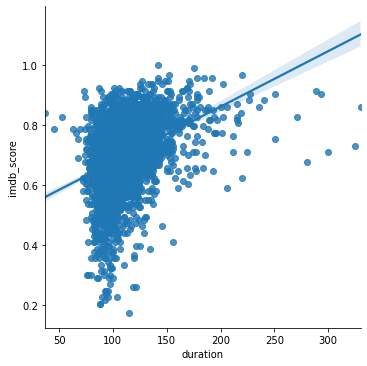

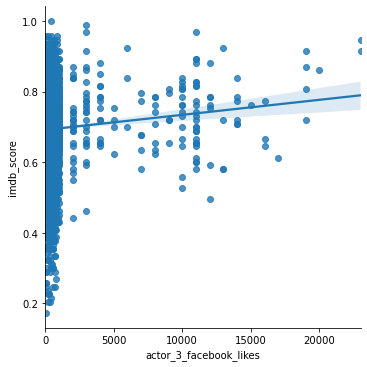

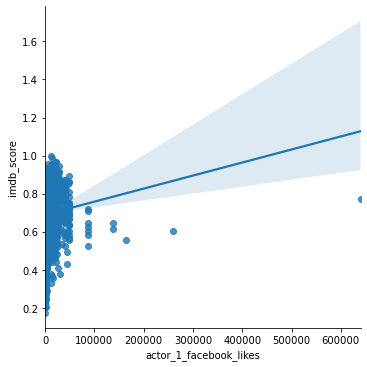

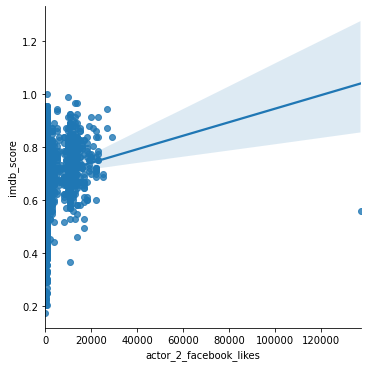

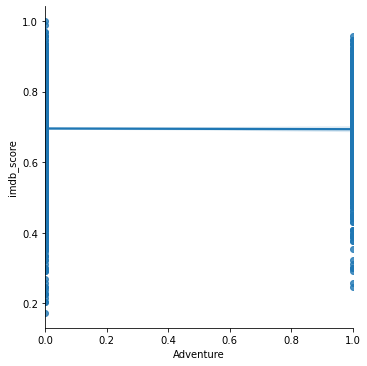

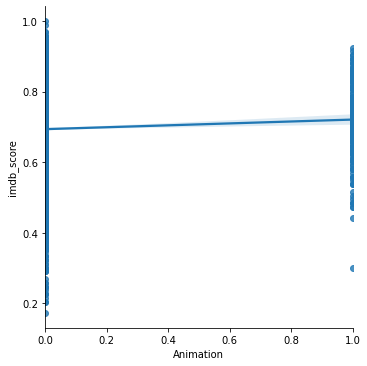

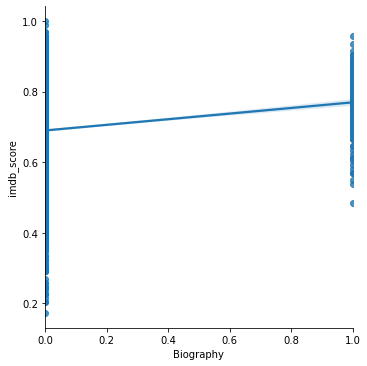

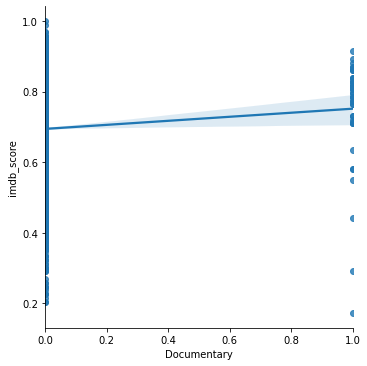

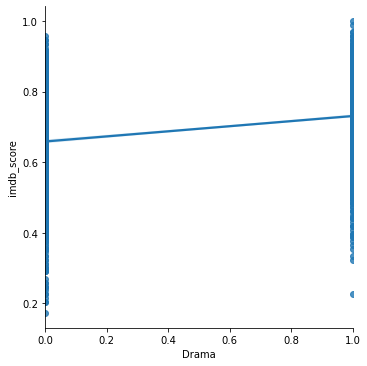

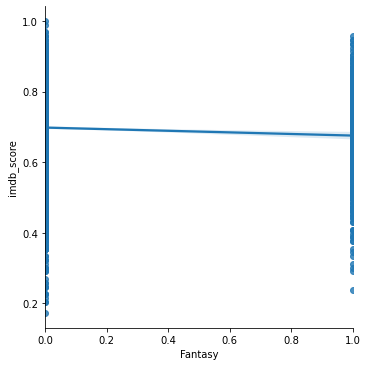

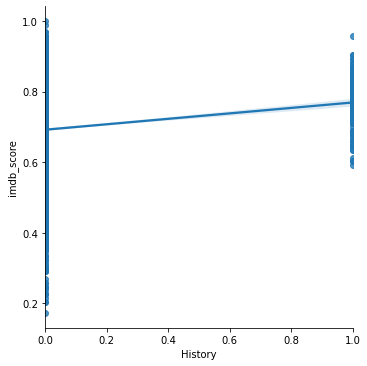

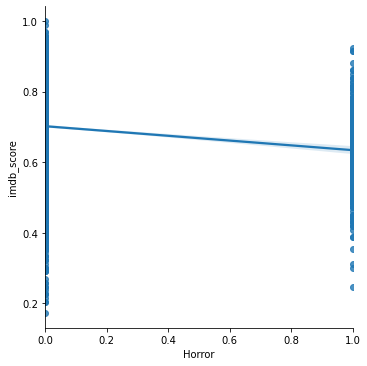

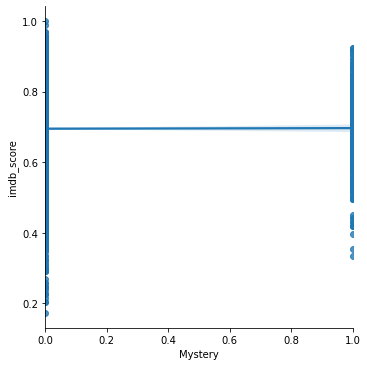

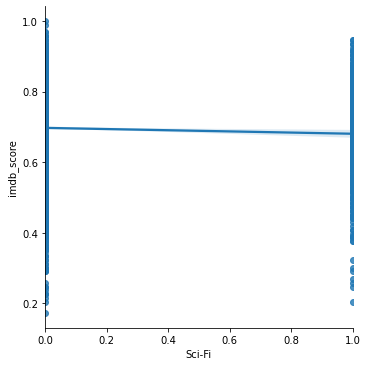

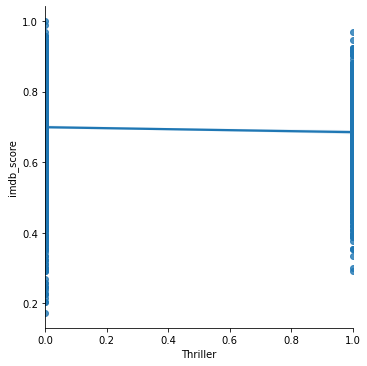

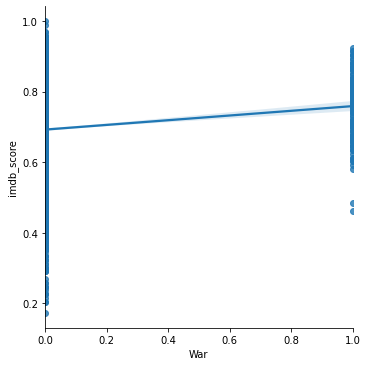

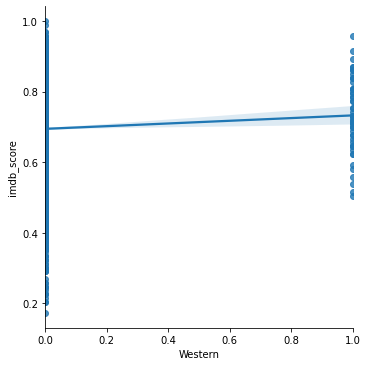

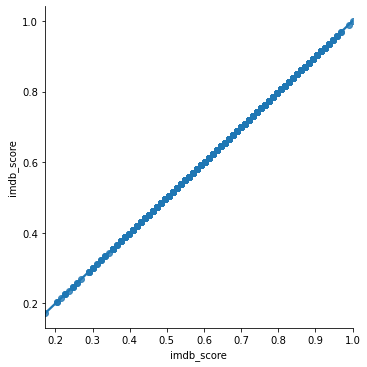

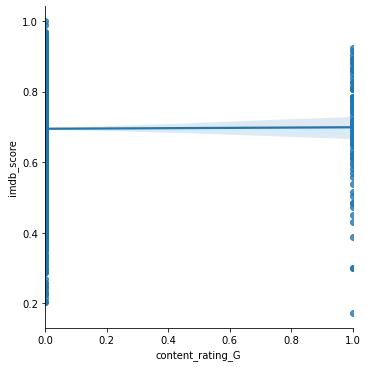

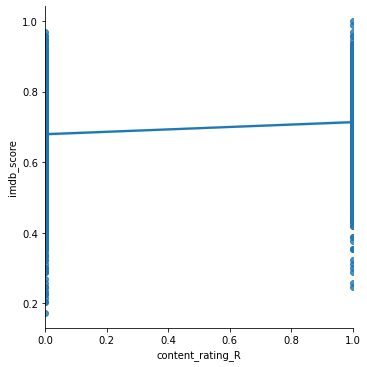

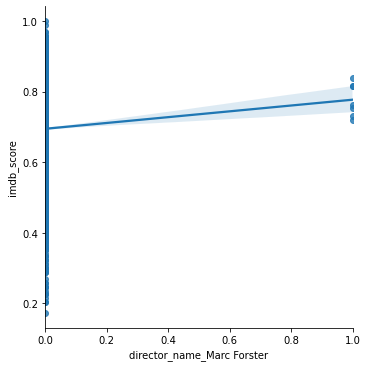

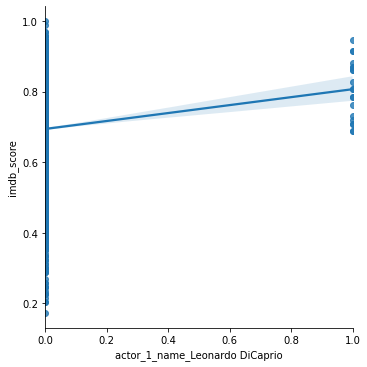

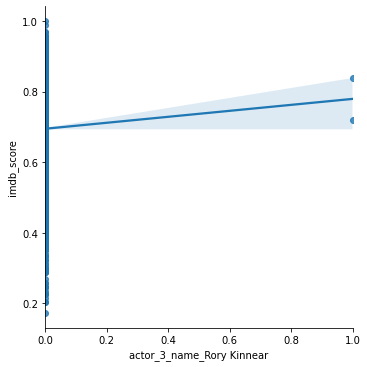

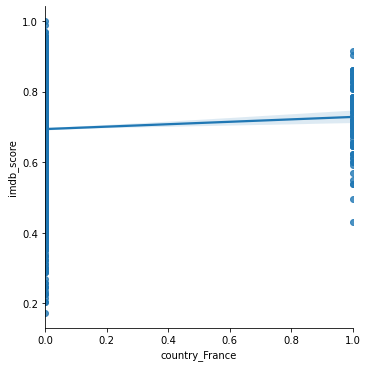

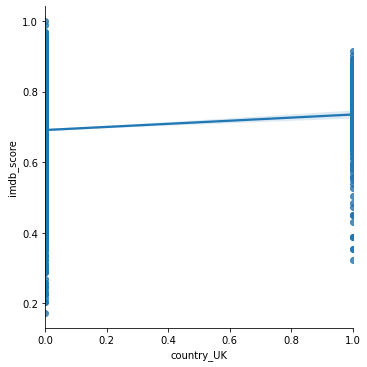

In [45]:
#Plotting a linear regression line for each of the important features

for x in important_features:
    sns.lmplot(data=moviesdf, x=x, y='imdb_score')